In [1]:
# Setup environment
# !apt-get -qq install xxd
# !pip3 install pandas numpy matplotlib
# !pip3 install tensorflow==2.13.0


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import glob
import random

file_path = "processed_data/*"

print(f"TensorFlow version = {tf.__version__}\n")

# Set a fixed random seed value, for reproducibility, this will allow us to get
# the same random numbers each time the notebook is run
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

# the list of gestures that data is available for
GESTURES = "abcdefghijklmnopqrstuvwxyz"

SAMPLES_PER_GESTURE = 120

NUM_GESTURES = 26

# create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_GESTURES = np.eye(NUM_GESTURES)

inputs = []
outputs = []

datafiles = glob.glob(file_path)
# datafiles.sort()
print(datafiles)

for datafile in datafiles:
    out = []    

    tensor = pd.read_csv(datafile)
    inputs.append(np.array(tensor.values.ravel()))
# np.array(t1.values.ravel())
    gesture_index=0
    for i in range(NUM_GESTURES):
        if datafile[15] == GESTURES[i]:
            gesture_index = i
    output = ONE_HOT_ENCODED_GESTURES[gesture_index]
    outputs.append(output)
    print ("processed ", datafile, "output=", GESTURES[gesture_index])
    

# read each csv file and push an input and output
# for gesture_index in range(NUM_GESTURES):
#   gesture = GESTURES[gesture_index]
#   print(f"Processing index {gesture_index} for gesture '{gesture}'.")
  
#   output = ONE_HOT_ENCODED_GESTURES[gesture_index]
  
#   df = pd.read_csv("./content/" + gesture + ".csv")
#   df = df.drop('lineno', axis=1)
  
#   # calculate the number of gesture recordings in the file
#   num_recordings = int(df.shape[0] / SAMPLES_PER_GESTURE)
  
#   print(f"\tThere are {num_recordings} recordings of the {gesture} gesture.")
#   print(df)
  
#   for i in range(num_recordings):
#     tensor = []
#     for j in range(SAMPLES_PER_GESTURE ):
#       print("process ", i , ", ", j)
#       index = i * SAMPLES_PER_GESTURE + j
#       # normalize the input data, between 0 to 1:
#       # - acceleration is between: -4 to +4
#       # - gyroscope is between: -2000 to +2000
#       tensor += [
#           (df['aX'][index] + 4) / 8,
#           (df['aY'][index] + 4) / 8,
#           (df['aZ'][index] + 4) / 8,
#           (df['gX'][index] + 2000) / 4000,
#           (df['gY'][index] + 2000) / 4000,
#           (df['gZ'][index] + 2000) / 4000
#       ]

#     inputs.append(tensor)
#     outputs.append(output)

# convert the list to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)

print("Data set parsing and preparation complete.")

2023-09-30 20:29:00.090571: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version = 2.13.0

['processed_data/j_79.dat', 'processed_data/d_54.dat', 'processed_data/b_111.dat', 'processed_data/x_25.dat', 'processed_data/o_126.dat', 'processed_data/m_70.dat', 'processed_data/c_49.dat', 'processed_data/m_64.dat', 'processed_data/q_15.dat', 'processed_data/b_105.dat', 'processed_data/x_31.dat', 'processed_data/d_40.dat', 'processed_data/v_34.dat', 'processed_data/x_19.dat', 'processed_data/j_45.dat', 'processed_data/d_68.dat', 'processed_data/c_61.dat', 'processed_data/c_3.dat', 'processed_data/q_29.dat', 'processed_data/c_75.dat', 'processed_data/m_58.dat', 'processed_data/j_51.dat', 'processed_data/v_20.dat', 'processed_data/d_97.dat', 'processed_data/z_1.dat', 'processed_data/s_119.dat', 'processed_data/d_83.dat', 'processed_data/j_86.dat', 'processed_data/j_92.dat', 'processed_data/u_65.dat', 'processed_data/g_39.dat', 'processed_data/i_14.dat', 'processed_data/c_100.dat', 'processed_data/r_78.dat', 'processed_data/c_114.dat', 'processed_data/n_123

In [3]:
inputs.shape

(3335, 720)

In [4]:
outputs.shape

(3335, 26)

In [5]:
# Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation
# https://stackoverflow.com/a/37710486/2020087
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("Data set randomization and splitting complete.")

Data set randomization and splitting complete.


In [6]:
# build the model and train it
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(100, activation='relu')) # relu is used for performance
# model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dense(50, activation='relu'))
model.add(tf.keras.layers.Dense(NUM_GESTURES, activation='softmax')) # softmax is used, because we only expect one gesture to occur per input
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(inputs_train, outputs_train, epochs=200, batch_size=1, validation_data=(inputs_validate, outputs_validate))



Epoch 1/200
2001/2001 [==============================] - 4s 2ms/step - loss: 0.0334 - mae: 0.0675 - val_loss: 0.0268 - val_mae: 0.0557
Epoch 2/200
2001/2001 [==============================] - 3s 2ms/step - loss: 0.0228 - mae: 0.0466 - val_loss: 0.0206 - val_mae: 0.0421
Epoch 3/200
2001/2001 [==============================] - 3s 2ms/step - loss: 0.0168 - mae: 0.0342 - val_loss: 0.0137 - val_mae: 0.0277
Epoch 4/200
2001/2001 [==============================] - 3s 2ms/step - loss: 0.0136 - mae: 0.0263 - val_loss: 0.0141 - val_mae: 0.0264
Epoch 5/200
2001/2001 [==============================] - 3s 2ms/step - loss: 0.0116 - mae: 0.0226 - val_loss: 0.0107 - val_mae: 0.0199
Epoch 6/200
2001/2001 [==============================] - 3s 2ms/step - loss: 0.0104 - mae: 0.0196 - val_loss: 0.0104 - val_mae: 0.0197
Epoch 7/200
2001/2001 [==============================] - 3s 2ms/step - loss: 0.0098 - mae: 0.0176 - val_loss: 0.0084 - val_mae: 0.0156
Epoch 8/200
2001/2001 [==============================] 

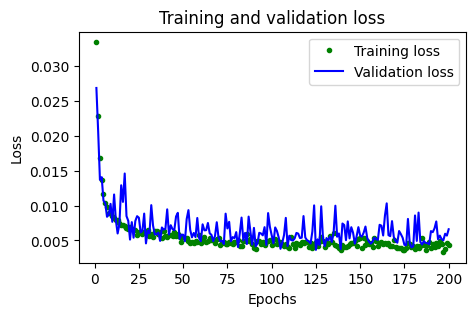

[5.0, 3.0]


In [7]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (5,3)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

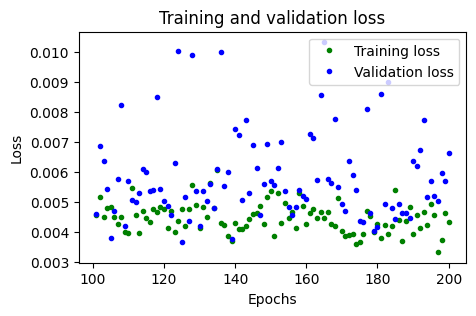

In [8]:
# graph the loss again skipping a bit of the start
SKIP = 100
plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

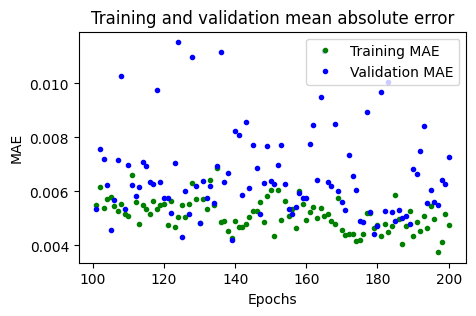

In [9]:
# graph of mean absolute error
mae = history.history['mae']
val_mae = history.history['val_mae']
plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


In [10]:
print(inputs_test.shape)
print(outputs_test.shape)

(667, 720)
(667, 26)


In [11]:
print("input shape" , inputs_test.shape)
print(type(inputs_test))
# print (len(data1))
# inputs_test = np.concatenate((inputs_test, [np.array(data1)]), axis=0)
# print("input shape" , inputs_test.shape)

input shape (667, 720)
<class 'numpy.ndarray'>


In [12]:
t1 = pd.read_csv("processed_data/a_1.dat")
# print(t1)
single_sample = np.array(t1.values.ravel())
# single_sample1 = (t1.melt().value.tolist())
print(type(single_sample))
prediction = model.predict(np.expand_dims(single_sample, axis=0))
# prediction1 = model.predict(np.expand_dims(single_sample1, axis=0))

# formatted_numbers = ["{:.2f}".format(number) for number in prediction[0]]

# print("Formatted Numbers:", formatted_numbers)
# print("Prediction:", prediction)

print("predictions =\n", np.round(prediction, decimals=3))
# print(single_sample)
# print(single_sample1)

<class 'numpy.ndarray'>
1/1 [==============================] - 0s 190ms/step
predictions =
 [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]]


In [13]:
# t1 = pd.read_csv("processed_data/a_1.dat")
# [np.array(t1.values.ravel())]

# inputs_test = np.concatenate((inputs_test, [np.array(t1.values.ravel())]), axis=0)
# # 

In [14]:
# use the model to predict the test inputs
predictions = model.predict(inputs_test)
print("pred shape" , predictions.shape)
# predictions = model.predict(inputs_test[0].reshape(1,1248))
# print(predictions[0])
# print(outputs_test[0])
# print (inputs_test[0])

# pd.DataFrame(inputs_test[0]).to_csv("test1.h", sep=',', encoding='utf-8', index=False, header=False)
# !echo "const unsigned char tt[] = {" > ./tt.h
# !cat "test1.csv" | xxd -i      >> ./tt.h
# !echo "};"                              >> ./tt.h

# print the predictions and the expected ouputs
print("predictions =\n", np.round(predictions, decimals=3))

print("actual =\n", outputs_test)
a = np.round(predictions - outputs_test, decimals=0)
print(a)
# Plot the predictions along with to the test data
# plt.clf()
# plt.title('Training data predicted vs actual values')
# plt.plot( outputs_test, 'b.', label='Actual')
# plt.plot( predictions, 'r.', label='Predicted')
# plt.show()


21/21 [==============================] - 0s 1ms/step
pred shape (667, 26)
predictions =
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
actual =
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0. -0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0. -0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]


In [15]:
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
# accuracy = accuracy_score(outputs_test, predictions)
# precision = precision_score(outputs_test, predictions)
# recall = recall_score(outputs_test, predictions)
# f1 = f1_score(outputs_test, predictions)
# conf_matrix = confusion_matrix(outputs_test, predictions)

# print(f"Accuracy: {accuracy}")
# print(f"Precision: {precision}")
# print(f"Recall: {recall}")
# print(f"F1-Score: {f1}")
# print(f"Confusion Matrix:\n{conf_matrix}")

In [16]:
# import matplotlib.pyplot as plt

# plt.scatter(outputs_test, predictions)
# plt.xlabel("True Values")
# plt.ylabel("Predictions")
# plt.show()

from sklearn.metrics import r2_score


r2 = r2_score(outputs_test, predictions)
print("r2=", r2)

r2= 0.8227340158079823


In [17]:
outputs_test[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [18]:
(predictions[0]+0.5).astype(int)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

In [19]:
# tf.saved_model.save(model, 'my_saved_model')

In [20]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("gesture_model.tflite", "wb").write(tflite_model)
  
import os
basic_model_size = os.path.getsize("gesture_model.tflite")
print("Model is %d bytes" % basic_model_size)
  
  

INFO:tensorflow:Assets written to: /var/folders/37/t8fhr8j953xfnbs16xcvwq3w0000gn/T/tmpyt9q_79o/assets


INFO:tensorflow:Assets written to: /var/folders/37/t8fhr8j953xfnbs16xcvwq3w0000gn/T/tmpyt9q_79o/assets


Model is 315996 bytes


2023-09-30 20:40:21.511807: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-09-30 20:40:21.511826: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-09-30 20:40:21.512660: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/37/t8fhr8j953xfnbs16xcvwq3w0000gn/T/tmpyt9q_79o
2023-09-30 20:40:21.513926: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2023-09-30 20:40:21.513941: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /var/folders/37/t8fhr8j953xfnbs16xcvwq3w0000gn/T/tmpyt9q_79o
2023-09-30 20:40:21.516768: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2023-09-30 20:40:21.517924: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-09-30 20:40:21.564794: I tensorflow/cc/saved_model/loader.

In [21]:
!echo "const unsigned char model[] = {" > ./content/model.h
!cat gesture_model.tflite | xxd -i      >> ./content/model.h
!echo "};"                              >> ./content/model.h

import os
model_h_size = os.path.getsize("./content/model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Header file, model.h, is 1,948,676 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.
